In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


In [2]:
path = 'https://raw.githubusercontent.com/FabioHodo/EIB2_ClimateRisk/main/cleaned%20data/data_imputed/imputed_knn/'
df = pd.read_csv(path +'Emissions_GHG_(fromCAIT).csv',index_col='Unnamed: 0' )
df

,Country,Code,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Albania,ALB,11.40,9.04,6.99,6.93,7.77,7.53,7.25,6.54,...,8.54,8.60,8.88,9.33,8.94,9.05,9.54,9.48,9.33,9.90
1,Algeria,DZA,96.00,94.87,94.50,102.03,99.78,103.99,105.30,109.39,...,156.40,166.21,167.32,179.68,189.89,193.59,203.79,211.66,209.41,211.50
2,Angola,AGO,150.61,151.28,151.61,152.39,152.54,156.90,161.39,156.01,...,173.99,180.66,186.83,220.92,185.95,203.34,185.10,207.66,182.19,176.85
3,Antigua and Barbuda,ATG,0.34,0.35,0.43,0.41,0.42,0.44,0.47,0.50,...,1.06,2.02,1.13,1.07,1.29,1.06,1.08,1.10,1.14,1.17
4,Argentina,ARG,323.84,328.83,333.22,335.73,340.81,341.39,344.46,346.24,...,468.33,452.69,440.34,450.10,464.88,462.89,456.74,460.21,469.73,469.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,VUT,0.47,0.48,0.50,0.53,0.54,0.54,0.57,0.57,...,0.70,0.70,0.71,0.75,0.75,0.75,0.81,0.81,0.84,0.84
163,Venezuela,VEN,303.14,304.92,308.93,315.26,318.02,326.54,331.00,337.59,...,265.49,261.47,291.82,323.30,343.49,373.61,359.46,352.14,352.08,338.14
164,Vietnam,VNM,25.63,28.49,31.00,37.69,43.31,49.46,56.03,63.80,...,209.45,231.71,251.16,235.76,237.24,249.25,263.12,306.26,320.67,319.54
165,Zambia,ZMB,485.43,484.96,484.28,483.00,481.44,478.95,444.46,405.54,...,471.05,412.65,460.49,432.46,455.21,468.32,440.83,473.30,495.17,495.99


In [3]:
def makeMonthly(country, scale = 20):
    '''
    Turn the yearly data into monthly using Brownian bridge algorithm
    Parameter:
        country: a string for the country name
        scale: an integer for the data scaling
    Return:
        the scaled monthly data
    '''
    #AnnualVal = Albania.loc["1990":"2017"]
    AnnualVal = country*scale
    n = (len(AnnualVal)-1)*12
    monthly = np.zeros(n+1)
    monthlyVal = np.zeros(n)
    for i in range(1, len(AnnualVal)+1):
        monthly[(i-1)*12] = AnnualVal[i-1]

    for i in range(1, len(AnnualVal)): #1-4
        for j in range ((i-1)*12+1, (i)*12): #0 to  47
            monthly[j] = monthly[j-1] + (monthly[(i)*12] - monthly[j-1])*(1/((i*12)-(j-1)))
            + (((i*12-j)*(1)/(i*12-(j-1)))**(1/2))*np.random.randn()
            monthlyVal[j-1] = monthly[j] -monthly[j-1]
    return monthly/scale

In [5]:
country='Argentina'
data = df[df['Country']==country]
data = data.loc[:,"1990":"2017"].T
monthly = makeMonthly(np.array(data), 10)
monthly = np.reshape(monthly, (-1, 1))

In [6]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(monthly)

In [19]:
#split train and test dataset
train_size = int(len(data)*0.7)
test_size = len(data)-train_size
train_data, test_data = data[0:train_size,:],data[train_size:len(data),:]
(train_size,test_size)

(227, 98)

In [8]:
def create_dataset(dataset,timestep = 10):
    data_x,data_y = [],[]
    for i in range(len(dataset)-timestep-1):
        a = dataset[i:i+timestep]
        data_x.append(a)
        data_y.append(dataset[i+timestep])
    return np.array(data_x),np.array(data_y)


In [9]:
x_train, y_train = create_dataset(train_data,timestep = 10)
x_test, y_test = create_dataset(test_data,timestep = 10)

In [10]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [51]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# model.add(LSTM(units = 50))
# model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(1, activation = 'relu'))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(x_train, y_train, validation_data = (x_test, y_test) ,epochs = 50, batch_size = 20,verbose =1,
         callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/50
11/11 [==============================] - 2s 88ms/step - loss: 0.1993 - val_loss: 0.4644
Epoch 2/50
11/11 [==============================] - 0s 28ms/step - loss: 0.0711 - val_loss: 8.8165e-04
Epoch 3/50
11/11 [==============================] - 0s 24ms/step - loss: 0.0296 - val_loss: 0.0365
Epoch 4/50
11/11 [==============================] - 0s 24ms/step - loss: 0.0142 - val_loss: 0.0046
Epoch 5/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0063 - val_loss: 0.0012
Epoch 6/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 7/50
11/11 [==============================] - 0s 25ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 8/50
11/11 [==============================] - 0s 24ms/step - loss: 0.0052 - val_loss: 0.0013
Epoch 9/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0038 - val_loss: 9.4556e-04
Epoch 10/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0045 - val_loss: 8.9928e-

In [52]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 10, 50)            10400     
_________________________________________________________________
dropout_21 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 10, 50)            20200     
_________________________________________________________________
dropout_22 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_23 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [53]:
train_predict = model.predict(x_train)

test_predict = model.predict(x_test)



In [54]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [55]:
math.sqrt(mean_squared_error(y_train,train_predict))

384.1197465077147

In [56]:
math.sqrt(mean_squared_error(y_test,test_predict))

461.2162606427689

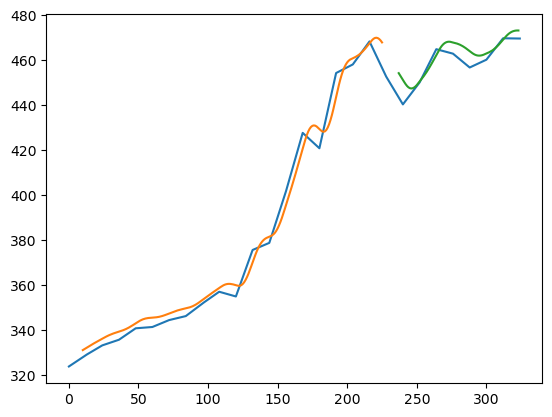

In [57]:
### Plotting 
# shift train predictions for plotting
look_back=10
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

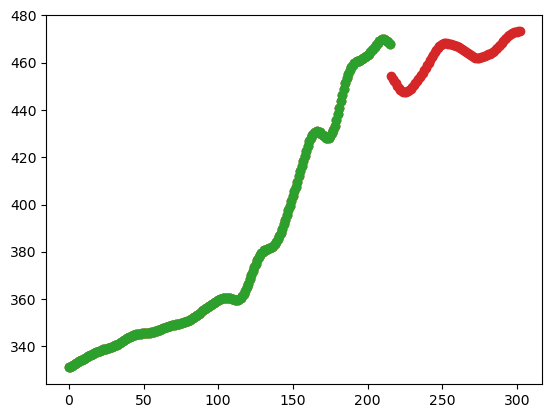

In [67]:
x = np.arange(0,216)
plt.scatter(x,train_predict)
y = np.arange(216,303)
plt.scatter(y,test_predict)
plt.show()

In [68]:
def predict(num_prediction, model):
    prediction_list = test_data[-look_back:]
    
    for i in range(num_prediction):
        x = prediction_list[-look_back:]
        #print(x)
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back:]
        
    return prediction_list

In [69]:
num_prediction = 13*12
x = predict(num_prediction, model)
prediction = scaler.inverse_transform(x.reshape(-1,1))

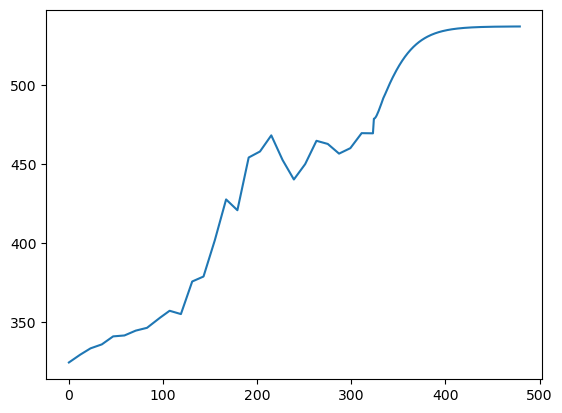

In [70]:
df3=monthly.tolist()
df3.extend(prediction)
plt.plot(df3[1:])
plt.show()

In [71]:
annual_prediction = prediction[11:num_prediction:12]
annual_prediction

array([[493.18310906],
       [508.54559698],
       [519.75081691],
       [527.08854508],
       [531.55925905],
       [534.15919285],
       [535.62956982],
       [536.44788939],
       [536.89921474],
       [537.1468515 ],
       [537.28240041],
       [537.35643578],
       [537.39687089]])

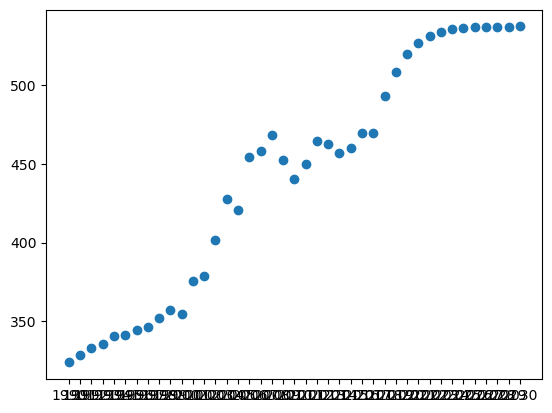

In [72]:
country='Argentina'
data = df[df['Country']==country]
data = data.loc[:,"1990":"2017"]
years = ['2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']
for i in range(len(years)):
    data[years[i]] = annual_prediction[i]

plt.scatter(data.columns,data)
plt.show()

In [ ]:
def rf_cv(n_estimators, min_samples_split, max_features, max_depth):
    val = cross_val_score(
        RandomForestClassifier(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=min(max_features, 0.999), # float
            max_depth=int(max_depth),
            random_state=2
        ),
        x, y, scoring='roc_auc', cv=5
    ).mean()
    return val

From Keras RNN Tutorial: "RNNs are tricky. Choice of batch size is important, choice of loss and optimizer is critical, etc. Some configurations won't converge."